In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import spacy
import gensim
from gensim import corpora
from gensim.utils import simple_preprocess
from gensim.corpora.dictionary import Dictionary
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from gensim.models.ldamodel import LdaModel
#from gensim.test.utils import common_corpus, common_dictionary
import os

# read corpus from csv
train = pd.read_csv(r"/users/wangp/work/mypython/train.csv")
# Set Column Names 
train.columns = ['ClassIndex', 'Title', 'Description']
# Combine Title and Description
# Because better accuracy than using them as separate features
X_train = train['Title'] + " " + train['Description'] 
doc_list = X_train[0:99].tolist() # only use 100 documents

print(doc_list[0:2])
# prepare data
nltk.download('stopwords')
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
stop_words = stopwords.words('english')

def save_model(lda_model,num):      
    #lda_ml = LDA(corpus=BoW_corpus, dictionary=dictionary,k_topic=6)
    lda_model.save(os.path.join('save_model','first_topic_model_'+str(num)))
#    print("Saved model")
    
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def sent_to_words(sentences):
    for sentence in sentences:
        yield(simple_preprocess(str(sentence), deacc=True))

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    [trigram_mod[bigram_mod[doc]] for doc in texts]


data_words = list(sent_to_words(doc_list))

bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

data_words_nostops = remove_stopwords(data_words)

data_words_bigrams = make_bigrams(data_words_nostops)
#data_words_trigrams = make_trigrams(data_words_nostops)
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=[
   'NOUN', 'ADJ', 'VERB', 'ADV'
])

#print(data_lemmatized[0:2])
#doc_tokenized = [simple_preprocess(doc) for doc in doc_list]
dictionary = corpora.Dictionary(data_lemmatized)
#BoW_corpus = [dictionary.doc2bow(doc, allow_update=True) for doc in doc_tokenized]
texts = data_lemmatized
BoW_corpus = [dictionary.doc2bow(text) for text in texts]

#if need to save corpus
#import pickle
#with open("corpus.pkl", "wb") as f:
#    pickle.dump(BoW_corpus, f) 
#with open("corpus_2.pkl", "wb") as f:
#    pickle.dump(BoW_corpus, f)     

iterations = 5
save_file = True
Topics = 5
   
for i in range(iterations):
        
    #id_words = [[(dictionary[id], count) for id, count in line] for line in BoW_corpus]
    lda_model = LdaModel(
       corpus=BoW_corpus, id2word=dictionary, num_topics=Topics, #random_state=100, 
       update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True
    )
    if save_file: 
        save_model(lda_model, i)

#    print('\nPerplexity: ', lda_model.log_perplexity(BoW_corpus))
    #print([ lda_model.get_topic_terms(tid, topn=3) for tid in range(2) ])
    # print each model's topic words
    print([ [(dictionary[wid], s) for (wid, s) in lda_model.get_topic_terms(tid, topn=10)] for tid in range(Topics)])
print("End")    

["Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.", 'Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\\which has a reputation for making well-timed and occasionally\\controversial plays in the defense industry, has quietly placed\\its bets on another part of the market.']


[nltk_data] Downloading package stopwords to
[nltk_data]     /users/wangp/work/nltk_data/...
[nltk_data]   Package stopwords is already up-to-date!


[[('say', 0.011656948), ('new', 0.0116354), ('market', 0.009771458), ('oil', 0.007891853), ('look', 0.007878684), ('russian', 0.00601999), ('could', 0.0060197106), ('company', 0.0060184896), ('place', 0.006015551), ('wireless', 0.0060138735)], [('record', 0.014738374), ('new', 0.012382522), ('election', 0.009997701), ('fall', 0.009989395), ('late', 0.009970569), ('trade', 0.0099471565), ('world', 0.0076172045), ('fund', 0.007612824), ('price', 0.007611096), ('oil', 0.0076059992)], [('good', 0.011868149), ('year', 0.010219437), ('say', 0.008571417), ('turn', 0.008571414), ('oil', 0.008569143), ('show', 0.0069586774), ('new', 0.006927331), ('share', 0.00692495), ('search', 0.00692308), ('slow', 0.006922996)], [('company', 0.0120933885), ('mail', 0.0087330835), ('phone', 0.008733028), ('get', 0.008724482), ('technology', 0.0053760717), ('market', 0.00537444), ('work', 0.0053741555), ('disc', 0.0053741424), ('employee', 0.0053741354), ('alligator', 0.005373724)], [('say', 0.011715257), ('s

In [3]:
# Calculate JS distance between each pair of models
from gensim.models.ldamulticore import LdaMulticore
from gensim.test.utils import datapath
diff_list = []
diff_pair = []
diff_num = []
for i in range(iterations-1):
    for j in range(i+1, iterations):
        #print(str(i), str(j))
        m1 = LdaMulticore.load(os.path.join('save_model','first_topic_model_'+str(i)))
        m2 = LdaMulticore.load(os.path.join('save_model','first_topic_model_'+str(j)))
        mdiff2, annotation2 = m1.diff(m2, distance='jensen_shannon')
        #print(mdiff2) # 5x5
        diff_num.append(str(i)+":"+str(j))
        diff_pair.append("Model " +str(i) + " vs. Model " + str(j))
        diff_list.append(mdiff2)        
        #print(annotation2[0,0])

In [5]:
import networkx as nx
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import min_weight_full_bipartite_matching
# one pair of models, bipartite matching
#t_size = 2*Topics
#multi_matrix = np.zeros((t_size,t_size),dtype=float) 
#multi_matrix.reshape((iterations-1)*Topics,(iterations-1)*Topics)
#print(multi_matrix.shape)

for i in range(len(diff_list)):
#    multi_matrix[0:Topics, Topics:(2*Topics)] = diff_list[i]
#    multi_matrix[Topics:(2*Topics), 0:Topics] = diff_list[i]

    #print(multi_matrix)
    graph = csr_matrix(diff_list[i])
    print(diff_pair[i])
#    print(min_weight_full_bipartite_matching(graph))
    row_ind, col_ind = min_weight_full_bipartite_matching(graph)
    for j in range(row_ind.size):
        print('topic %s - topic %s : %s' % (row_ind[j]%Topics, col_ind[j]%Topics, graph[row_ind[j], col_ind[j]]))
        if (row_ind[j]%Topics == Topics-1):
            print("===============================================")


Model 0 vs. Model 1
topic 0 - topic 2 : 0.6767653167331246
topic 1 - topic 0 : 0.6776936608578256
topic 2 - topic 1 : 0.750874657934273
topic 3 - topic 3 : 0.703492150197022
topic 4 - topic 4 : 0.7606099871153142
Model 0 vs. Model 2
topic 0 - topic 3 : 0.7649375905753466
topic 1 - topic 4 : 0.7259247122604391
topic 2 - topic 2 : 0.7145356323879426
topic 3 - topic 0 : 0.749189023251474
topic 4 - topic 1 : 0.6657924824343009
Model 0 vs. Model 3
topic 0 - topic 4 : 0.599975298577158
topic 1 - topic 1 : 0.5646866574825727
topic 2 - topic 3 : 0.7159689342826647
topic 3 - topic 0 : 0.6586227872690622
topic 4 - topic 2 : 0.7239387567324767
Model 0 vs. Model 4
topic 0 - topic 3 : 0.6439138290755166
topic 1 - topic 0 : 0.6821002326217754
topic 2 - topic 4 : 0.7679084644340004
topic 3 - topic 2 : 0.647792468023477
topic 4 - topic 1 : 0.6845026556358683
Model 1 vs. Model 2
topic 0 - topic 4 : 0.6675557703695789
topic 1 - topic 3 : 0.5890221680558645
topic 2 - topic 1 : 0.8332818569061845
topic 3 

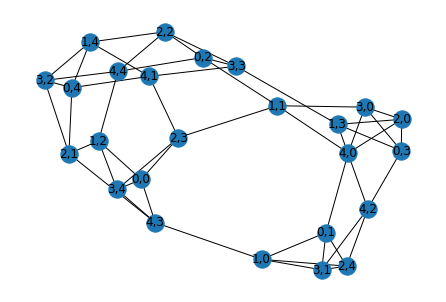

['1,0', '0,1', '2,4', '3,1']
['3,3', '2,2', '0,2']
['1,1', '4,0', '3,0']
['2,0', '4,0', '3,0']
['2,0', '0,3', '3,0']
['2,0', '0,3', '1,3']
['4,1', '0,4', '1,4']
['0,3', '4,2', '1,3']
['4,2', '2,4', '3,1']
['0,4', '3,2', '1,4']
['0,4', '3,2', '2,1']
['2,2', '0,2', '4,4']
['1,2', '0,0', '3,4']
['0,0', '3,4', '4,3']
['0,0', '3,4', '2,3']
clique number: 15


In [8]:
# define Maxmum edges the clique includes
# default is 3
# if the iteration is large, there will be many cliques
Max_num_clique = 3

G = nx.Graph()

for i in range(len(diff_list)):
    graph = csr_matrix(diff_list[i])
    row_ind, col_ind=min_weight_full_bipartite_matching(graph)
#    print(diff_pair[i])
#    print(row_ind, col_ind)
    
    num_list = diff_num[i].split(":")
    start_model_num = int(num_list[0])
    end_model_num = int(num_list[1])
    for j in range(row_ind.size):
        #print('topic %s - topic %s : %s' % (row_ind[i]%Topics, col_ind[i]%Topics, graph[row_ind[i], col_ind[i]]))
        #if (row_ind[i]%Topics == Topics-1):
        nodes1 = str(start_model_num)+","+str(row_ind[j])
        nodes2 = str(end_model_num)+","+str(col_ind[j])
#        print(graph[row_ind[j], col_ind[j]])
        G.add_edge(nodes1, nodes2, weight=graph[row_ind[j], col_ind[j]])
        
#layout = nx.spring_layout(G)
nx.draw(G, with_labels = True)
#nx.draw_networkx_edge_labels(G, pos=layout)
plt.show()

from networkx.algorithms import clique
cg = list(clique.find_cliques(G))
#print(len(cg))
#from networkx.algorithms.approximation import clique
#print(clique.max_clique(G))

count = 0
for i in range(len(cg)):
    if (len(cg[i]) >= Max_num_clique):
#        print(i)
        print(cg[i])
        count += 1
#        nx.draw(cg[i], with_labels = True)
print("clique number: " + str(count))

In [89]:
all_node = set()
for i in range(len(cg)):
    all_node = set.union(all_node,set(cg[i]))
print(len(all_node))    

50


In [9]:
# print clique weight

for k in range (len(cg)):
    if (len(cg[k]) >= Max_num_clique):
        print(cg[k])
        sum_weight = 0
        for i in range(len(cg[k])):
            if (i == len(cg[k])-1):
                print(cg[k][0]+"-"+cg[k][i]+": "+str(G.get_edge_data(cg[k][0],cg[k][i])['weight'])) 
                sum_weight += float(G.get_edge_data(cg[k][0],cg[k][i])['weight'])
            else:    
                print(cg[k][i]+"-"+cg[k][i+1]+": "+str(G.get_edge_data(cg[k][i],cg[k][i+1])['weight']))
                sum_weight += float(G.get_edge_data(cg[k][0],cg[k][i+1])['weight'])
        print(sum_weight)

['1,0', '0,1', '2,4', '3,1']
1,0-0,1: 0.6776936608578256
0,1-2,4: 0.7259247122604391
2,4-3,1: 0.6117034241949532
1,0-3,1: 0.8156122204922338
2.976473872211872
['3,3', '2,2', '0,2']
3,3-2,2: 0.8859737404269711
2,2-0,2: 0.7145356323879426
3,3-0,2: 0.7159689342826647
2.3179116089923006
['1,1', '4,0', '3,0']
1,1-4,0: 0.6570897215293318
4,0-3,0: 0.768435791429704
1,1-3,0: 0.728684162086366
2.114458045702064
['2,0', '4,0', '3,0']
2,0-4,0: 0.748877834938742
4,0-3,0: 0.768435791429704
2,0-3,0: 0.6827570759511121
2.114391986840966
['2,0', '0,3', '3,0']
2,0-0,3: 0.749189023251474
0,3-3,0: 0.6586227872690622
2,0-3,0: 0.6827570759511121
2.114703175153698
['2,0', '0,3', '1,3']
2,0-0,3: 0.749189023251474
0,3-1,3: 0.703492150197022
2,0-1,3: 0.7563862035947142
2.2619614304409024
['4,1', '0,4', '1,4']
4,1-0,4: 0.6845026556358683
0,4-1,4: 0.7606099871153142
4,1-1,4: 0.7392497994807752
2.1630022545974184
['0,3', '4,2', '1,3']
0,3-4,2: 0.647792468023477
4,2-1,3: 0.6951737504306102
0,3-1,3: 0.7034921501970